In [ ]:
!pip install install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu memcnn

In [ ]:
pip install git+https://github.com/VLL-HD/FrEIA.git

In [ ]:
!pip install sklearn geoopt seaborn

In [1]:
def quadratic_formula(a,b,c):
    r = torch.sqrt(torch.square(b) - 4*a*c)
    x1 = (-b + r)/(2*a)
    #x2 = (-b - r)/(2*a)
    return x1.view(-1, 1)#, x2.view(-1, 1)

def get_intersection_with_unit_sphere(self, y):
    d = y - self.center
    a = d.matmul(d.T).diagonal()
    b = 2*d.matmul(y.T).diagonal()
    c = y.matmul(y.T).diagonal() - 1 
    t1 = quadratic_formula(a, b, c) #pos always seems the right
    p = d*t1 + y
    return p


In [2]:
import matplotlib.pyplot
import geoopt
X = np.random.normal(size=(5000, 2))
print(np.max(np.linalg.norm(X, axis=-1)))
plt.scatter(*X[:, :].T)

NameError: name 'np' is not defined

(-1.1, 1.1, -1.1, 1.1)

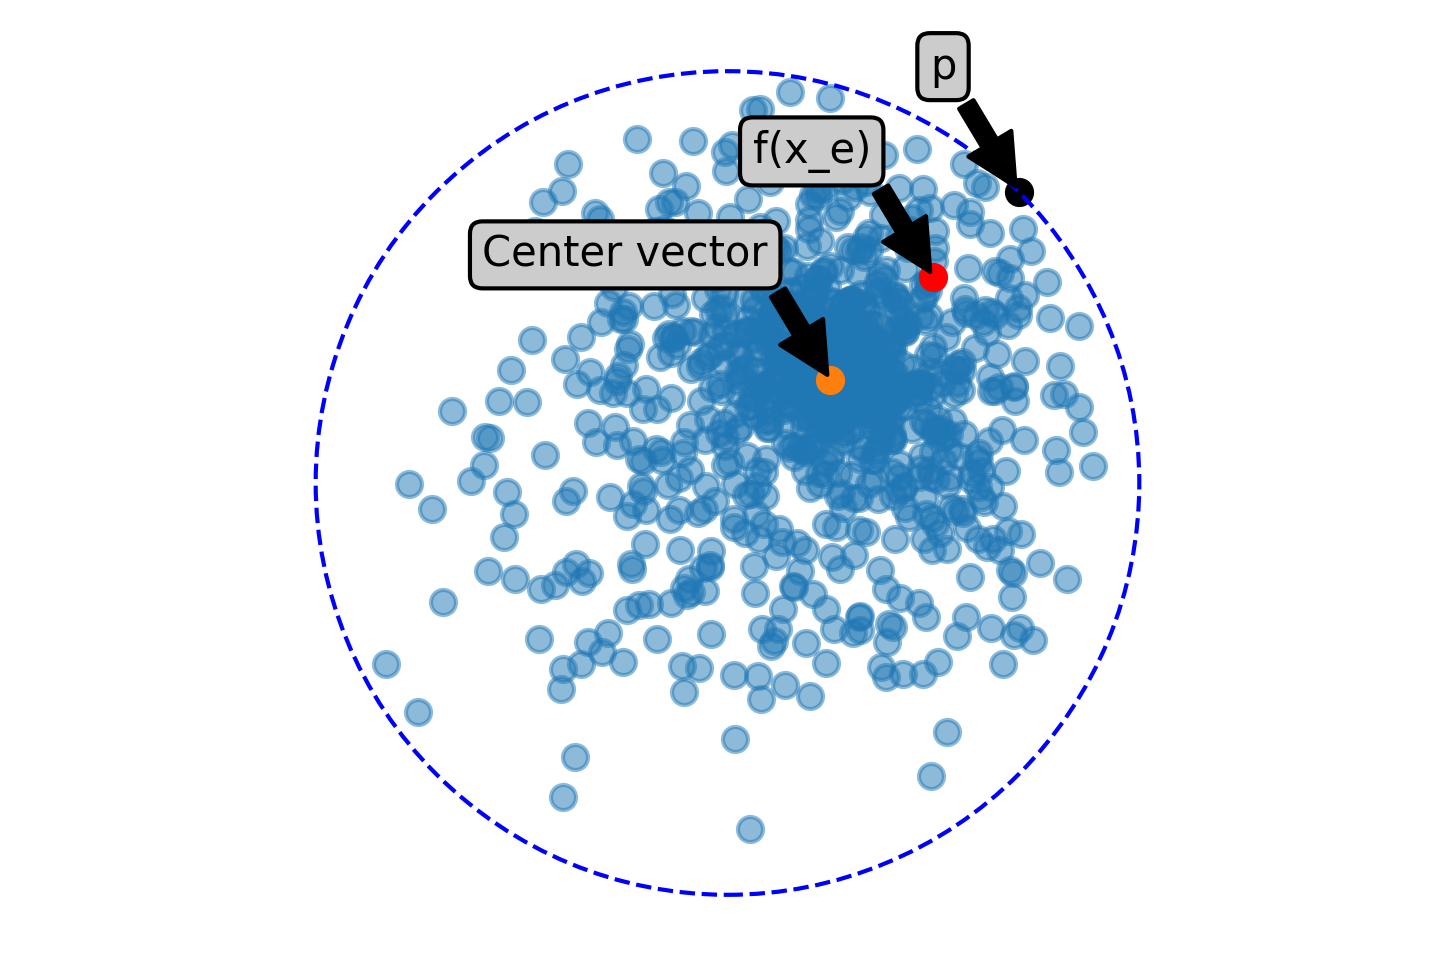

In [10]:
fig, ax = plt.subplots(dpi=300)

ax.scatter(*(rejection_sampling(1000, 2, torch.tensor([0.25, 0.25]), Beta(1,2))).T, alpha=0.5 , label='Samples') 

ax.annotate('Center vector',
            xy=(0.25, 0.25), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')
ax.scatter(0.25, 0.25)
ax.scatter(0.5, 0.5, c='r')
ax.annotate('f(x_e)',
            xy=(0.5, 0.5), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')
ax.scatter(1/np.sqrt(2), 1/np.sqrt(2), c='k')
ax.annotate('p',
            xy=(1/np.sqrt(2), 1/np.sqrt(2)), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')
circ = plt.Circle((0, 0), 1, color='b', ls='--', fill=False)
ax.add_patch(circ)
ax.axis('off')
ax.axis('equal')

In [ ]:
plt.scatter(*(sample_points_on_unit_sphere(10000, 2)*np.random.rand(10000)[:, np.newaxis]**(1/np.sqrt(2))).T, alpha=0.2)

In [11]:
import torch
import torch.nn.functional as F

x = torch.rand(3, 2)
y = torch.rand(4, 2)

import matplotlib.pyplot as plt


#plt.scatter(*x.T)
#plt.scatter(*y.T)

diffs = (y.view(1, -1, 2) -  x.view(-1, 1, 2))
t = torch.linspace(0, 1, 30)
pairs = (diffs.unsqueeze(-1).expand(-1, -1, -1, 30)*t + x.view(-1, 1, 2, 1)).view(-1, 2, 30)
print((diffs.unsqueeze(-1).expand(-1, -1, -1, 30)*t + x.view(-1, 1, 2, 1))[:, :, :, 0])
a, b = pairs[:, :, :-1].clone().permute(0, 2, 1), pairs[:, :, 1:].clone().permute(0, 2, 1)
F.pairwise_distance(a,b).sum(dim=-1).mean()

tensor([[[0.4526, 0.5408],
         [0.4526, 0.5408],
         [0.4526, 0.5408],
         [0.4526, 0.5408]],

        [[0.0535, 0.1072],
         [0.0535, 0.1072],
         [0.0535, 0.1072],
         [0.0535, 0.1072]],

        [[0.3556, 0.2360],
         [0.3556, 0.2360],
         [0.3556, 0.2360],
         [0.3556, 0.2360]]])


tensor(0.5417)

In [9]:
import numpy as np

    
model = UpSample()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

for i in range(10000):
    X = np.random.normal(size=(1000, 2))
    y = np.linalg.norm(X, axis=-1) > 1
    loss = loss_fn(model(torch.Tensor(X)), torch.Tensor(y).view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(loss.item())

NameError: name 'UpSample' is not defined

In [ ]:
inn(x)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import FrEIA.framework as Ff
import FrEIA.modules as Fm

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.beta import Beta
def quadratic_formula(a,b,c):
    r = torch.sqrt(torch.square(b) - 4*a*c)
    x1 = (-b + r)/(2*a)
    #x2 = (-b - r)/(2*a)
    return x1.view(-1, 1)#, x2.view(-1, 1)


class PredicateTransform(nn.Module):
    
    def __init__(self, dim, depth, internal_width=64):
        super(PredicateTransform, self).__init__()
        self.internal_width = internal_width
        self.inn = Ff.SequenceINN(dim)
        for k in range(depth):
            self.inn.append(Fm.AllInOneBlock, subnet_constructor=lambda x, y: self.subnet_fc(x,y), permute_soft=True)
        self.inn.apply(PredicateTransform.init_weights)
        
    def subnet_fc(self, c_in, c_out):
        return nn.Sequential(nn.Linear(c_in, self.internal_width), nn.GELU(),
                        nn.Linear(self.internal_width,  c_out))

    def forward(self, x):
        y, _ = self.inn(x,jac=False)
        return y
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            m.bias.data.fill_(0.01)
    
    def inverse(self, x):
        y, _ = self.inn(x, rev=True, jac=False)
        return y
    
            
def sample_points_on_unit_sphere(n, dim):
    y = torch.normal(0, 1, size=(n, dim))
    y /= torch.norm(y, dim=-1).view(n, -1)
    return y


def rejection_sampling(n, dim, center, dist):
    assert dim == 2
    theta = torch.rand(n)*2*3.141592653589
    d = torch.stack((torch.sin(theta), torch.cos(theta)), dim=-1)
    a = d.matmul(d.T).diagonal()
    b = 2*d.matmul(center)
    c = center.dot(center) - 1
    t1 = quadratic_formula(a, b, c)
    p = d*t1 + center
    r = dist.rsample((n,)) * torch.norm(p - center, dim=-1)
    return (d*r.view(-1, 1)) + center

class EPredicate(nn.Module):
    def __init__(self, dim, depth=5, width=5):
        super(EPredicate, self).__init__()
        self.dim = dim
        self.beta = torch.nn.Parameter(torch.tensor(0.))
        self.scale_ = torch.nn.Parameter(torch.tensor(1.0))
        self.center_length_ = torch.nn.Parameter(torch.rand(1))
        self.center_theta_ = torch.nn.Parameter(torch.rand(1)*2*3.14159265358979323)
        self.transform = PredicateTransform(self.dim, depth=depth, internal_width=width)
    
    @property 
    def center(self):
        direction = torch.cat((torch.sin(self.center_theta_), torch.cos(self.center_theta_)))
        return direction*0.75*torch.tanh(self.center_length_)
    
    @property 
    def scale(self):
        return 10.0
        
    def get_intersection_with_unit_sphere(self, y):
        d = y - self.center
        a = d.matmul(d.T).diagonal()
        b = 2*d.matmul(y.T).diagonal()
        c = y.matmul(y.T).diagonal() - 1
        t1 = quadratic_formula(a, b, c)
        p = d*t1 + y
        return p
    
    def get_draw_paths(self, x, y, resolution=25):
        z = torch.vstack((x, y))
        z = self.transform(z)
        f_x = z[:len(x), :]
        f_y = z[len(x):, :]
        diffs = (f_y.view(1, -1, 2) -  f_x.view(-1, 1, 2))
        t = torch.linspace(0, 1, resolution)
        pairs = (diffs.unsqueeze(-1).expand(-1, -1, -1, resolution)*t + f_x.view(-1, 1, 2, 1)).view(-1, 2, resolution).permute(0, 2, 1)
        pairs = pairs.contiguous()
        pairs = self.inverse(pairs.view(-1, 2)).view(*pairs.shape)
        return pairs

    def distance(self, x, y, resolution=25):
        #pairs = self.get_draw_paths(x, y, resolution=resolution)
        #a, b = pairs[:, :-1, :].contiguous(), pairs[:, 1:, :].contiguous()
        #return F.pairwise_distance(a,b).sum(dim=-1)
        z = torch.vstack((x, y))
        z = self.transform(z)
        f_x = z[:len(x), :]
        f_y = z[len(x):, :]
        return torch.cdist(f_x, f_y)
    
    def forward(self, X):
        if not self.training:
            return self.get_value(X)
        y = self.transform(X) 
        p = self.get_intersection_with_unit_sphere(y)
        return torch.sigmoid(self.scale*((p-self.center).norm(dim=-1) - (y-self.center).norm(dim=-1)))
        #return torch.exp(((p-self.center).norm(dim=-1) - (y-self.center).norm(dim=-1)))
        
        
    def get_value(self, X):
        y = self.transform(X)
        p = self.get_intersection_with_unit_sphere(y)
        return ((p-self.center).norm(dim=-1) >= (y-self.center).norm(dim=-1)).to(dtype=torch.float)
    
    def inverse(self, x):
        return self.transform.inverse(x)
    
    def surface_given_sphere(self, sphere):
        return self.inverse(sphere)# - self.origin
    
    def surface(self, n=10):
        sphere = sample_points_on_unit_sphere(n, self.dim)
        return self.inverse(sphere)# - self.origin
    
    def sample(self, n=10):
        sphere = rejection_sampling(n, self.dim, self.center, Beta(1, torch.tanh(self.beta) + 2))
        return self.inverse(sphere)
    
    def sample_uniform(self, n=10):
        sphere = sample_points_on_unit_sphere(n, self.dim) * 0.95
        sphere *= torch.pow(torch.rand((n, 1)), 1/np.sqrt(2)).detach()
        return self.inverse(sphere)


Or = lambda *x: torch.max(torch.stack(x, dim=0), dim=0).values
And = lambda *x: torch.min(torch.stack(x,dim=0), dim=0).values

def Or(*x):
    x = torch.stack(x, dim=0)
    return torch.mean(torch.topk(x, max(1, int(len(x)*0.25)), dim=0).values, dim=0)

def And(*x):
    x = torch.stack(x, dim=0)
    return torch.mean(torch.topk(x, max(1, int(len(x)*0.25)), dim=0, largest=False).values, dim=0)

Gen = lambda x, P: torch.mean(P(x))
Not = lambda x: 1 - x

samples = 200

def Every(x, P, n=samples):
    x = x.sample_uniform(n)
    Q = P(x)
    return And(*Q)

def Each(x, P, n=samples):
    x = x.sample_uniform(n)
    Q = Or(P(x), Not(stuff['exists'](x)))
    return And(*Q)

def No(x, P, n=samples):
    x = x.sample_uniform(n)
    Q = Or(Not(P(x)), Not(stuff['exists'](x)))
    return And(*Q)

def ThereAre(P, n=samples):
    return Or(*stuff['exists'](P.sample_uniform(n)))

def Is(P, Q, n=samples):
    sphere = sample_points_on_unit_sphere(n, 2)
    ps = P.surface_given_sphere(sphere)
    qs = Q.surface_given_sphere(sphere)
    d = torch.norm(ps-qs, dim=-1)
    return torch.mean(torch.exp(-d))

def Similar(P, Q, R=None, n=samples, alpha=1.0):
    x = P.sample(int(np.sqrt(n)))
    y = Q.sample(int(np.sqrt(n)))
    if R is None:
        return torch.exp(-torch.cdist(x.view(1, -1, 2), y.view(1, -1, 2))).mean()
    else:
        return torch.exp(-R.distance(x, y)*alpha).mean()


In [73]:
(torch.rand(5, 2).view(-1, 1, 2) - torch.ones(7, 2).view(1, -1, 2)).shape

torch.Size([5, 7, 2])

In [6]:
class EAdjective(nn.Module):
    def __init__(self, dim, depth=5, width=5, in_dim=None):
        super(EAdjective, self).__init__()
        self.dim = dim
        self.width = width
        self.in_dim = in_dim
        if self.in_dim is None:
            self.in_dim = self.dim 
            
        l = [
                nn.Linear(self.dim * 2, self.width),
                nn.ReLU()
            ] + \
            max(0, depth-2)*[
                nn.Linear(self.width, self.width),
                nn.ReLU()
            ]+ \
            [
                nn.Linear(self.width, self.in_dim),
                nn.ReLU()
            ]
        self.transform = nn.Sequential(*l)

    def forward(self, x, y, relative=lambda x: x):
        x = self.transform(torch.cat((x, relative(torch.rand_like(x))), dim=-1))
        y = self.transform(torch.cat((y, relative(torch.rand_like(y))), dim=-1))
        z = F.relu(y.view(1, -1, self.in_dim) - x.view(-1, 1, self.in_dim)) ** 2
        if not self.training:
            return z == 0
        return torch.exp(-z)
    
    def inverse(self, x):
        return self.transform.inverse(x)

In [ ]:
for k, v in stuff.items():
    v.eval()
prop = []
prop.append(Every(stuff['male_lion'], stuff['lion'], samples))
prop.append(Every(stuff['female_lion'], stuff['lion'], samples)) 
prop.append(No(stuff['female_lion'], stuff['male_lion'], samples))
prop.append(No(stuff['male_lion'], stuff['female_lion'], samples))
prop.append(Every(stuff['lion'], lambda x: Or(stuff['male_lion'](x), stuff['female_lion'](x)), samples))

prop.append(Gen(stuff['lion'].sample(samples), stuff['has_mane']))
prop.append(Gen(stuff['male_lion'].sample(samples), stuff['has_mane']))
prop.append(1 - Gen(stuff['female_lion'].sample(samples), stuff['has_mane']))

prop.append(Gen(stuff['lion'].sample(samples), stuff['give_live_birth']))
prop.append(Gen(stuff['female_lion'].sample(samples), stuff['give_live_birth']))
prop.append(1 - Gen(stuff['male_lion'].sample(samples), stuff['give_live_birth']))
prop

KeyError: 'people'

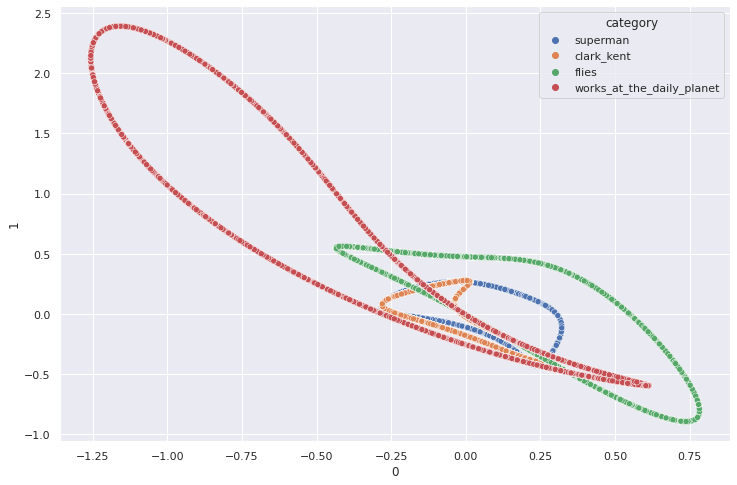

In [14]:
import geoopt
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
with torch.no_grad():
    n = 5000
    names = stuff.keys()
    df = pd.DataFrame(torch.cat([stuff[k].sample(n).detach() for k in names]))
    df['category'] = sum([[s]*n for s in names], [])

    surface_df = pd.DataFrame(torch.cat([stuff[k].surface(n).detach() for k in names]))
    surface_df['category'] = sum([[s]*n for s in names], [])

    sns.set(rc={'figure.figsize':(12,8)})
    sns.scatterplot(data=df[df.category.isin(('jim', 'john', 'lion'))], x=0, y=1, hue='category', alpha=.05,
               hue_order=names, legend=False)
    sns.scatterplot(data=surface_df, x=0, y=1, hue='category', hue_order=names)

    resolution = 500
    N = 1

    
    jim = torch.tensor(df.loc[df['category'] == 'jim', (0,1)].sample(N).to_numpy())
    john = torch.tensor(df.loc[df['category'] == 'john', (0,1)].sample(1).to_numpy())
    
    people_line = stuff['people'].get_draw_paths(john, jim, resolution=resolution).view(-1, 2).T
    fighter_line = stuff['fighter'].get_draw_paths(john, jim, resolution=resolution).view(-1, 2).T
    geodesic_df = pd.DataFrame(torch.cat((people_line, fighter_line), dim=-1).T)
    geodesic_df['category'] = ['people']*resolution*N + ['fighter']*resolution*N
    sns.lineplot(data=geodesic_df, x=0, y=1, hue='category', hue_order=names, 
                 linewidth=4,
                 legend=False, estimator=None,sort=False)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)

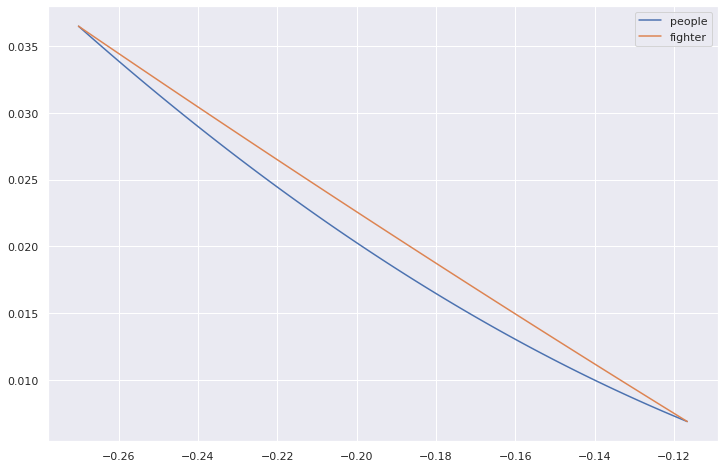

In [53]:
with torch.no_grad():
    plt.plot(*stuff['people'].get_draw_paths(john, jim, resolution=100).view(-1, 2).T, label='people')
    plt.plot(*stuff['fighter'].get_draw_paths(john, jim, resolution=100).view(-1, 2).T, label='fighter')
plt.legend()

In [7]:

stuff = {
    "superman": EPredicate(2, depth=4, width=128),
    "clark_kent": EPredicate(2, depth=4, width=128),
    "flies": EPredicate(2, depth=4, width=128),
    "works_at_the_daily_planet": EPredicate(2, depth=4, width=128),
}

def get_props(stuff):
    prop = []
    prop.append(Is(stuff['superman'], stuff['clark_kent']))
    prop.append(Gen(stuff['superman'].sample(samples), stuff['flies']))
    prop.append(1-Gen(stuff['clark_kent'].sample(samples), stuff['flies']))
    prop.append(Gen(stuff['clark_kent'].sample(samples), stuff['works_at_the_daily_planet']))
    prop.append(1-Gen(stuff['superman'].sample(samples), stuff['works_at_the_daily_planet']))
    return prop

In [515]:
D = 4
W = 24
stuff = {
    "lion": EPredicate(2, depth=D, width=W),
    "male_lion": EPredicate(2, depth=D, width=W),
    "female_lion": EPredicate(2, depth=D, width=W),
    'has_mane': EPredicate(2, depth=D, width=W),
    'give_live_birth': EPredicate(2, depth=D, width=W),
    'exists': EPredicate(2, depth=D, width=W)
}

def get_props(stuff):
    prop = []
    prop.append(Every(stuff['male_lion'], stuff['lion']))
    prop.append(Every(stuff['female_lion'], stuff['lion'])) 
    prop.append(No(stuff['female_lion'], stuff['male_lion']))
    prop.append(No(stuff['male_lion'], stuff['female_lion']))
    prop.append(Every(stuff['lion'], lambda x: Or(stuff['male_lion'](x), stuff['female_lion'](x))))
        
    prop.append(Gen(stuff['lion'].sample(samples), stuff['has_mane']))
    prop.append(Gen(stuff['male_lion'].sample(samples), stuff['has_mane']))
    prop.append(Not(Gen(stuff['female_lion'].sample(samples), stuff['has_mane'])))
    
    prop.append(Gen(stuff['lion'].sample(samples), stuff['give_live_birth']))
    prop.append(Gen(stuff['female_lion'].sample(samples), stuff['give_live_birth']))
    prop.append(Not(Gen(stuff['male_lion'].sample(samples), stuff['give_live_birth'])))
    
    prop.append(ThereAre(stuff['lion']))
    prop.append(ThereAre(stuff['female_lion']))
    prop.append(ThereAre(stuff['male_lion']))
    
    prop.append(No(stuff['male_lion'], stuff['give_live_birth']))
    prop.append(No(stuff['female_lion'], stuff['has_mane']))

    return prop

In [92]:
alpha=1.0
D = 2
W = 8
stuff = {
    "jim": EPredicate(2, depth=D, width=W),
    "john": EPredicate(2, depth=D, width=W),
    "fighter": EPredicate(2, depth=D, width=W),
    'people': EPredicate(2, depth=D, width=W)
}

def get_props(stuff):
    prop = []    
    prop.append(Every(stuff['fighter'], stuff['people']))

    prop.append(Gen(stuff['jim'].sample(samples), lambda x: Not(stuff['john'](x))))
    prop.append(Gen(stuff['john'].sample(samples), lambda x: Not(stuff['jim'](x))))
    
    
    prop.append(Gen(stuff['jim'].sample(samples), stuff['people']))
    prop.append(Gen(stuff['john'].sample(samples), stuff['people']))
    prop.append(Gen(stuff['jim'].sample(samples), stuff['fighter']))
    prop.append(Gen(stuff['john'].sample(samples), stuff['fighter']))

    prop.append(Similar(stuff['john'], stuff['jim'], stuff['fighter'], alpha=alpha))
    prop.append(Not(Similar(stuff['john'], stuff['jim'], stuff['people'], alpha=alpha)))

    return prop

In [105]:
alpha=1.0
D = 2
W = 8
stuff = {
    'jim': EPredicate(2, depth=D, width=W),
    'john': EPredicate(2, depth=D, width=W),
    'people': EPredicate(2, depth=D, width=W),
    'fighter': EPredicate(2, depth=D, width=W),
}
adjs = {
    'good' : EAdjective(2, depth=D, width=W),
}

def more_than(R, a, b, relative=lambda x: x):
    a_samples = a.sample(samples)
    b_samples = b.sample(50)
    d = R(a_samples, b_samples, relative).mean(dim=-1)
    d = torch.sigmoid(10.0*(d-0.75))
    return d.mean()
                 
def get_props(stuff):
    prop = []    
    prop.append(Every(stuff['fighter'], stuff['people']))

    prop.append(Gen(stuff['jim'].sample(samples), lambda x: Not(stuff['john'](x))))
    prop.append(Gen(stuff['john'].sample(samples), lambda x: Not(stuff['jim'](x))))
    
    prop.append(more_than(adjs['good'], stuff['jim'], stuff['john'], stuff['fighter'].transform))
    prop.append(more_than(adjs['good'], stuff['john'], stuff['jim'], stuff['people'].transform))
    prop.append(Gen(stuff['jim'].sample(samples), stuff['people']))
    prop.append(Gen(stuff['john'].sample(samples), stuff['people']))
    
    #prop.append(Similar(stuff['john'], stuff['jim'], stuff['fighter'], alpha=alpha))
    #prop.append(Not(Similar(stuff['john'], stuff['jim'], stuff['people'], alpha=alpha)))

    return prop

In [8]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
N = 1000

optimizer = torch.optim.Adam(sum([list(x.parameters()) for _, x in stuff.items()], []), lr=0.003)
loss_fn = torch.nn.BCEWithLogitsLoss()


avg_loss = 0
for i in tqdm(range(N)):
    prop = get_props(stuff)
    for _, s in stuff.items():
        prop.append(F.relu(s.sample_uniform().norm(dim=-1) - 3).mean() * 0.75)
        
    
    #for _, s in stuff.items():
    #    prop.append(F.relu(0.5 - s.sample_uniform().norm(dim=-1)).mean())
    
    p = torch.stack(prop)
    p[:-len(stuff)] = -torch.log(p[:-len(stuff)]+1e-5)
    loss = p.mean()
    optimizer.zero_grad()
    
    loss.backward()
    avg_loss += (p[:-len(stuff)].mean()).item()
    for _, s in stuff.items():
        torch.nn.utils.clip_grad_norm_(s.parameters(), 1.0)
    optimizer.step()
    if i % 100 == 0 and i > 0:
        print(avg_loss / 100)
        avg_loss = 0

  0%|          | 0/1000 [00:00<?, ?it/s]

0.3986250685155392
0.12025592215359211
0.06921042934060097
0.05170267019420862
0.04122706390917301
0.03421137558296323
0.02922873405739665
0.024969734121114015
0.022925660144537688


In [101]:
((Gen(stuff['lion'].sample(500), lambda x: And(stuff['male_lion'](x), stuff['female_lion'](x))),
Gen(stuff['lion'].sample(500), lambda x: And(stuff['has_mane'](x), stuff['give_live_birth'](x)))),

(Every(stuff['lion'], lambda x: And(stuff['male_lion'](x), stuff['female_lion'](x))),
No(stuff['lion'], lambda x: And(stuff['has_mane'](x), stuff['give_live_birth'](x)))))

KeyError: 'lion'

In [103]:
-Every(stuff['lion'], lambda x: Or(stuff['male_lion'](x), stuff['female_lion'](x)))

KeyError: 'lion'

In [108]:
prop

[tensor(0.9999, grad_fn=<MeanBackward1>),
 tensor(0.9999, grad_fn=<MeanBackward0>),
 tensor(0.9996, grad_fn=<MeanBackward0>),
 tensor(0.9238, grad_fn=<MeanBackward0>),
 tensor(0.9241, grad_fn=<MeanBackward0>),
 tensor(0.9994, grad_fn=<MeanBackward0>),
 tensor(0.9993, grad_fn=<MeanBackward0>),
 tensor(0., grad_fn=<MulBackward0>),
 tensor(0., grad_fn=<MulBackward0>),
 tensor(0., grad_fn=<MulBackward0>),
 tensor(0., grad_fn=<MulBackward0>)]